# Model NEATM 余亮亮 修改alpha phi 
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$


# LS_NEATM
## import & define const

In [53]:
#import
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math as mh 

#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9              #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
eta_guess = [1.2,0.7]
D_guess = [400,200000]
logf_guess = [1,0.1,1]
eta_piror = [0.5,2.8]
D_piror = [0,2500000]
Hv = 20
G = 0.15
Ndd = 10
lamdai = [12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

### Model_hhq

In [54]:
def neatm_hhq(Ndd,eta,D,delta,d,alpha,lamda,A):   
    sum = 0
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = mh.pow((1-A)*Fsun/(eta*epsi*sigma*d*d),0.25,)
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*mh.pow(mh.cos(thei),0.25)*mh.pow(mh.cos(phii),0.25)
            integral = mh.cos(alpha)**2*mh.cos(alpha-thei)/(mh.exp(h*cl/(lamda*kB*T))-1)
            sum = sum + dxdy*integral
    #print('hhq',delta)
    F = (epsi*mh.pow(D,2)*mh.pi*h*cl*cl)*sum/(2*mh.pow(delta,2)*mh.pow(lamda,5))

    F = F*(lamda*1e-6)**2/cl*1e29 
    #print('hhq2',delta)
    return F
def Model_neatm_hhq(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    #print("neatm ",delta)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_hhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda1,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_hhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda2,A)
        #print("neatm",i,'=',delta[i])
    #print('2',delta)
    return flux

### Model_jhx

In [55]:
#constants---------------------------------------------------------------------------
#emissivity:
epsi = 0.9
#stefan-boltzman:
sigmas = 5.67*10**(-8)
#solar constant:
f_solar = 1367.5
#planck constant:
h = 6.62607015 * 10 ** (-34)
#speed of light
c = 3.0 * 10 ** 8 
#boltzmann constant
kb = 1.380649 * 10 ** (-23)
#astronomical unit in unit of meter
au = 1.496 * 10 ** 11
def neatm_jhx(Ndd,dast,dao,alpha,Dia,wlenth,yita,A):
    #dast: distance from asteroid to Sun :d
    #dobs: distance from observer to Sun  :dd
    #dao:  distance from asteroid to observer :delta
    #alpha: solar phase
    #dia: diameter of asteroid
    #wlenth: wavelength
    #yita: beaming parameter
    #A: bond albedo
	
	T_ss = ((1 - A) * f_solar / epsi / yita / sigmas / dast ** 2) ** 0.25
	Nd = int(Ndd)
	phi = np.zeros((Nd-1,1))
	theta = np.zeros((Nd-1,1))
	for i in range(0,Nd-1):#phi , theta is the angle from subsolar point
			phi[i] = -pi/2.0 + i * pi / Nd
			theta[i] = -pi/2.0 + i * pi / Nd
	nj = np.floor(((alpha - pi / 2.0) + pi / 2.0) / (pi / Nd)) 
	dphi, dtheta = pi/Nd,abs(alpha-pi)/Nd
	ss = dphi*dtheta#dtheta*dphi
	wlenth = wlenth * 10 ** (-6)
	temp = np.zeros((len(phi),len(theta)))
	flux = 0.0
	flux_con = epsi * Dia ** 2 * pi  * h * c ** 2  / (wlenth ** 5)
	for j in range(0,len(phi)):
		for k in range(int(nj),len(theta)):
			temp[j,k] = T_ss * np.cos(theta[k]) ** 0.25 * np.cos(phi[j]) ** 0.25
			flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
	return flux
def Model_neatm_jhx(theta,x,lamda):
    eta,D =theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    nn = len(delta)
    flux = np.zeros(nn)
    for i in range(0,int(nn/2)-1):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda1,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
    for i in range(int(nn/2),nn):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda2,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
        
    #print('hello',flux)
    return flux

## read data file

/tmp/ipykernel_663526/4220248000.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


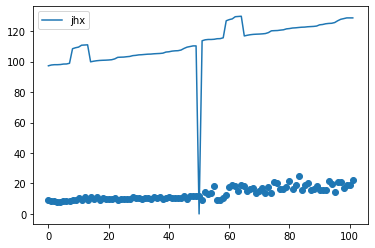

In [56]:
name = '2ev5'
obsec = np.loadtxt(f'ObsECs_{name}.txt')
#print(obsec)
obsdat = np.loadtxt(f'obs_{name}.txt')
#obstime  = np.loadtxt(f'fobs_{name}.txt')
#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#earth-sun
#print(delta_N)
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
y = obsdat
nn = len(d_N)
nt = np.arange(nn)
plt.scatter(nt,y)
#delta_N,d_N,alpha_N = x
theta = [2.4,1038]
#flux = Model_neatm_hhq(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
flux2 = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
x = (delta_N,d_N,alpha_N)
yerr = 0.1*y
#plt.plot(nt,flux,label = 'hhq')
plt.plot(nt,flux2,label = 'jhx')
plt.legend()


## define LOSS_function

In [57]:
#loss Function
def loss_func(y,yerr,y_cal):
    n = len(y)
    #for i in range(n):
    #    print(y[i],y_cal[i],mh.pow((y[i]-y_cal[i])/1,1))
    return sum(np.power((y-y_cal)/yerr,2))/n


In [58]:
#initial
eta_gss = [0.1,2.8,0.1]
D_gss = [200,500,1]

In [59]:
n_eta = int((eta_gss[1]-eta_gss[0])/eta_gss[2]+1)                     
n_D = int((D_gss[1]-D_gss[0])/D_gss[2]+1)
Ntime = n_eta*n_D         
print(f'It`s need {Ntime} setps',f'eta={n_eta} d={n_D}')

loss = 10e6
nstep = 0
Di = D_gss[0]
for i in tqdm.tqdm(range(n_D)):
    etai = eta_gss[0]
    for j in tqdm.tqdm(range(n_eta), leave=False):
        flux = np.zeros(nn)
        flux = Model_neatm_jhx(theta=(etai,Di),x=x,lamda=lamdai)
        lossi = loss_func(y,yerr,flux)
        if lossi<loss :
            loss = lossi
            eta_fit = etai
            D_fit  = Di
            print(f'step {nstep} :loss = {lossi} eta = {eta_fit} D = {D_fit}')
        etai = etai + eta_gss[2]
        #print(etai)
        nstep = nstep + 1
    Di = Di + D_gss[2]


It`s need 8127 setps eta=27 d=301


  0%|          | 0/301 [00:00<?, ?it/s]

step 0 :loss = 440.9824100270445 eta = 0.1 D = 200


/tmp/ipykernel_663526/4220248000.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


step 1 :loss = 130.09311254679747 eta = 0.2 D = 200
step 2 :loss = 52.771755924793105 eta = 0.30000000000000004 D = 200


step 3 :loss = 26.053175717765043 eta = 0.4 D = 200
step 4 :loss = 16.31697852093501 eta = 0.5 D = 200


step 5 :loss = 13.52193365639503 eta = 0.6 D = 200


  1%|          | 2/301 [00:04<10:46,  2.16s/it]

step 60 :loss = 13.478716542395421 eta = 0.7 D = 202


  1%|          | 3/301 [00:06<10:43,  2.16s/it]

step 87 :loss = 13.31070286945452 eta = 0.7 D = 203


  1%|▏         | 4/301 [00:08<10:37,  2.15s/it]

step 114 :loss = 13.160489278269287 eta = 0.7 D = 204


  2%|▏         | 5/301 [00:10<10:34,  2.14s/it]

step 141 :loss = 13.0283442250671 eta = 0.7 D = 205


  2%|▏         | 6/301 [00:13<10:41,  2.18s/it]

step 168 :loss = 12.914537605451073 eta = 0.7 D = 206


  2%|▏         | 7/301 [00:15<10:49,  2.21s/it]

step 195 :loss = 12.819340750915622 eta = 0.7 D = 207


  3%|▎         | 8/301 [00:17<10:55,  2.24s/it]

step 222 :loss = 12.74302642550252 eta = 0.7 D = 208


  3%|▎         | 9/301 [00:20<11:17,  2.32s/it]

step 249 :loss = 12.685868822590965 eta = 0.7 D = 209


  3%|▎         | 10/301 [00:22<11:08,  2.30s/it]

step 276 :loss = 12.648143561815276 eta = 0.7 D = 210


  4%|▎         | 11/301 [00:24<11:00,  2.28s/it]

step 303 :loss = 12.6301276861046 eta = 0.7 D = 211


  4%|▍         | 13/301 [00:28<10:44,  2.24s/it]

step 358 :loss = 12.493947133586763 eta = 0.7999999999999999 D = 213


  5%|▍         | 14/301 [00:31<10:39,  2.23s/it]

step 385 :loss = 12.353327333950997 eta = 0.7999999999999999 D = 214


  5%|▍         | 15/301 [00:33<10:29,  2.20s/it]

step 412 :loss = 12.228939075775186 eta = 0.7999999999999999 D = 215


  5%|▌         | 16/301 [00:35<10:44,  2.26s/it]

step 439 :loss = 12.12101459790437 eta = 0.7999999999999999 D = 216


  6%|▌         | 17/301 [00:38<11:09,  2.36s/it]

step 466 :loss = 12.02978729549266 eta = 0.7999999999999999 D = 217


  6%|▌         | 18/301 [00:41<11:39,  2.47s/it]

step 493 :loss = 11.955491718025387 eta = 0.7999999999999999 D = 218


  6%|▋         | 19/301 [00:43<12:14,  2.60s/it]

step 520 :loss = 11.898363567415267 eta = 0.7999999999999999 D = 219


  7%|▋         | 20/301 [00:46<12:22,  2.64s/it]

step 547 :loss = 11.85863969616933 eta = 0.7999999999999999 D = 220


  7%|▋         | 21/301 [00:49<12:56,  2.77s/it]

step 574 :loss = 11.836558105623583 eta = 0.7999999999999999 D = 221


  7%|▋         | 22/301 [00:52<12:44,  2.74s/it]

step 601 :loss = 11.832357944242588 eta = 0.7999999999999999 D = 222
step 602 :loss = 11.829739016857317 eta = 0.8999999999999999 D = 222


  8%|▊         | 23/301 [00:55<12:47,  2.76s/it]

step 629 :loss = 11.689881720884621 eta = 0.8999999999999999 D = 223


  8%|▊         | 24/301 [00:57<12:25,  2.69s/it]

step 656 :loss = 11.564676670988518 eta = 0.8999999999999999 D = 224


  8%|▊         | 25/301 [01:00<12:16,  2.67s/it]

step 683 :loss = 11.45432619162966 eta = 0.8999999999999999 D = 225


  9%|▊         | 26/301 [01:03<12:23,  2.70s/it]

step 710 :loss = 11.359033562174973 eta = 0.8999999999999999 D = 226


  9%|▉         | 27/301 [01:06<12:55,  2.83s/it]

step 737 :loss = 11.279003015638773 eta = 0.8999999999999999 D = 227


  9%|▉         | 28/301 [01:09<12:59,  2.85s/it]

step 764 :loss = 11.214439737468334 eta = 0.8999999999999999 D = 228


 10%|▉         | 29/301 [01:11<12:36,  2.78s/it]

step 791 :loss = 11.165549864372084 eta = 0.8999999999999999 D = 229


 10%|▉         | 30/301 [01:14<12:49,  2.84s/it]

step 818 :loss = 11.132540483188782 eta = 0.8999999999999999 D = 230


 10%|█         | 31/301 [01:17<12:46,  2.84s/it]

step 845 :loss = 11.11561962979596 eta = 0.8999999999999999 D = 231


 11%|█         | 32/301 [01:20<12:44,  2.84s/it]

step 872 :loss = 11.114996288056 eta = 0.8999999999999999 D = 232
step 873 :loss = 11.035848290955874 eta = 0.9999999999999999 D = 232


 11%|█         | 33/301 [01:23<12:30,  2.80s/it]

step 900 :loss = 10.915878246511584 eta = 0.9999999999999999 D = 233


 11%|█▏        | 34/301 [01:25<12:07,  2.73s/it]

step 927 :loss = 10.809518017820874 eta = 0.9999999999999999 D = 234


 12%|█▏        | 35/301 [01:28<11:51,  2.68s/it]

step 954 :loss = 10.716947168686724 eta = 0.9999999999999999 D = 235


 12%|█▏        | 36/301 [01:30<11:34,  2.62s/it]

step 981 :loss = 10.638346065243063 eta = 0.9999999999999999 D = 236


 12%|█▏        | 37/301 [01:33<11:38,  2.64s/it]

step 1008 :loss = 10.573895875158579 eta = 0.9999999999999999 D = 237


 13%|█▎        | 38/301 [01:36<11:26,  2.61s/it]

step 1035 :loss = 10.52377856686701 eta = 0.9999999999999999 D = 238


 13%|█▎        | 39/301 [01:38<11:28,  2.63s/it]

step 1062 :loss = 10.488176908823 eta = 0.9999999999999999 D = 239


 13%|█▎        | 40/301 [01:41<11:24,  2.62s/it]

step 1089 :loss = 10.467274468782394 eta = 0.9999999999999999 D = 240


 14%|█▎        | 41/301 [01:44<11:28,  2.65s/it]

step 1116 :loss = 10.461255613106218 eta = 0.9999999999999999 D = 241
step 1117 :loss = 10.39621015291538 eta = 1.0999999999999999 D = 241


 14%|█▍        | 42/301 [01:46<11:21,  2.63s/it]

step 1144 :loss = 10.285362603082401 eta = 1.0999999999999999 D = 242


 14%|█▍        | 43/301 [01:49<11:36,  2.70s/it]

step 1171 :loss = 10.18713750102822 eta = 1.0999999999999999 D = 243


 15%|█▍        | 44/301 [01:52<11:28,  2.68s/it]

step 1198 :loss = 10.101695295454688 eta = 1.0999999999999999 D = 244


 15%|█▍        | 45/301 [01:54<11:06,  2.60s/it]

step 1225 :loss = 10.029197120229034 eta = 1.0999999999999999 D = 245


 15%|█▌        | 46/301 [01:57<11:00,  2.59s/it]

step 1252 :loss = 9.969804793849255 eta = 1.0999999999999999 D = 246


 16%|█▌        | 47/301 [01:59<10:50,  2.56s/it]

step 1279 :loss = 9.923680818926583 eta = 1.0999999999999999 D = 247


 16%|█▌        | 48/301 [02:02<11:09,  2.65s/it]

step 1306 :loss = 9.890988381684142 eta = 1.0999999999999999 D = 248


 16%|█▋        | 49/301 [02:04<10:59,  2.62s/it]

step 1333 :loss = 9.871891351471406 eta = 1.0999999999999999 D = 249


 17%|█▋        | 50/301 [02:07<10:59,  2.63s/it]

step 1360 :loss = 9.866554280293794 eta = 1.0999999999999999 D = 250
step 1361 :loss = 9.777941933462252 eta = 1.2 D = 250


 17%|█▋        | 51/301 [02:10<10:49,  2.60s/it]

step 1388 :loss = 9.678782328360233 eta = 1.2 D = 251


 17%|█▋        | 52/301 [02:13<11:07,  2.68s/it]

step 1415 :loss = 9.591445486160579 eta = 1.2 D = 252


 18%|█▊        | 53/301 [02:15<11:07,  2.69s/it]

step 1442 :loss = 9.516076151508747 eta = 1.2 D = 253


 18%|█▊        | 54/301 [02:18<11:04,  2.69s/it]

step 1469 :loss = 9.452819661476987 eta = 1.2 D = 254


 18%|█▊        | 55/301 [02:21<10:54,  2.66s/it]

step 1496 :loss = 9.401821945197916 eta = 1.2 D = 255


 19%|█▊        | 56/301 [02:23<10:57,  2.68s/it]

step 1523 :loss = 9.363229523509181 eta = 1.2 D = 256


 19%|█▉        | 57/301 [02:26<11:06,  2.73s/it]

step 1550 :loss = 9.337189508608828 eta = 1.2 D = 257


 19%|█▉        | 58/301 [02:29<11:04,  2.73s/it]

step 1577 :loss = 9.323849603720982 eta = 1.2 D = 258
step 1578 :loss = 9.284830566862992 eta = 1.3 D = 258


 20%|█▉        | 59/301 [02:31<10:55,  2.71s/it]

step 1605 :loss = 9.188053240839638 eta = 1.3 D = 259


 20%|█▉        | 60/301 [02:34<10:36,  2.64s/it]

step 1632 :loss = 9.102308416817008 eta = 1.3 D = 260


 20%|██        | 61/301 [02:37<10:33,  2.64s/it]

step 1659 :loss = 9.02772721220476 eta = 1.3 D = 261


 21%|██        | 62/301 [02:40<10:53,  2.73s/it]

step 1686 :loss = 8.964441262331297 eta = 1.3 D = 262


 21%|██        | 63/301 [02:42<10:57,  2.76s/it]

step 1713 :loss = 8.912582720180247 eta = 1.3 D = 263


 21%|██▏       | 64/301 [02:45<10:36,  2.68s/it]

step 1740 :loss = 8.872284256134657 eta = 1.3 D = 264


 22%|██▏       | 65/301 [02:47<10:26,  2.66s/it]

step 1767 :loss = 8.843679057728558 eta = 1.3 D = 265


 22%|██▏       | 66/301 [02:50<10:32,  2.69s/it]

step 1794 :loss = 8.826900829405712 eta = 1.3 D = 266
step 1795 :loss = 8.80655256883103 eta = 1.4000000000000001 D = 266


 22%|██▏       | 67/301 [02:53<10:31,  2.70s/it]

step 1822 :loss = 8.714536293627061 eta = 1.4000000000000001 D = 267


 23%|██▎       | 68/301 [02:56<10:20,  2.66s/it]

step 1849 :loss = 8.632892408646136 eta = 1.4000000000000001 D = 268


 23%|██▎       | 69/301 [02:58<10:25,  2.69s/it]

step 1876 :loss = 8.561740543190409 eta = 1.4000000000000001 D = 269


 23%|██▎       | 70/301 [03:01<10:19,  2.68s/it]

step 1903 :loss = 8.501200783356875 eta = 1.4000000000000001 D = 270


 24%|██▎       | 71/301 [03:04<10:19,  2.69s/it]

step 1930 :loss = 8.451393671845244 eta = 1.4000000000000001 D = 271


 24%|██▍       | 72/301 [03:07<10:28,  2.75s/it]

step 1957 :loss = 8.412440207771168 eta = 1.4000000000000001 D = 272


 24%|██▍       | 73/301 [03:09<10:17,  2.71s/it]

step 1984 :loss = 8.384461846484657 eta = 1.4000000000000001 D = 273


 25%|██▍       | 74/301 [03:12<10:10,  2.69s/it]

step 2011 :loss = 8.367580499393574 eta = 1.4000000000000001 D = 274
step 2012 :loss = 8.344968588665253 eta = 1.5000000000000002 D = 274


 25%|██▍       | 75/301 [03:15<10:08,  2.69s/it]

step 2039 :loss = 8.259447968968775 eta = 1.5000000000000002 D = 275


 25%|██▌       | 76/301 [03:17<09:59,  2.67s/it]

step 2066 :loss = 8.183741262404942 eta = 1.5000000000000002 D = 276


 26%|██▌       | 77/301 [03:20<10:03,  2.70s/it]

step 2093 :loss = 8.117958297894424 eta = 1.5000000000000002 D = 277


 26%|██▌       | 78/301 [03:23<10:01,  2.70s/it]

step 2120 :loss = 8.062209310350173 eta = 1.5000000000000002 D = 278


 26%|██▌       | 79/301 [03:25<09:57,  2.69s/it]

step 2147 :loss = 8.0166049405355 eta = 1.5000000000000002 D = 279


 27%|██▋       | 80/301 [03:28<09:53,  2.68s/it]

step 2174 :loss = 7.981256234926007 eta = 1.5000000000000002 D = 280


 27%|██▋       | 81/301 [03:31<09:53,  2.70s/it]

step 2201 :loss = 7.956274645575203 eta = 1.5000000000000002 D = 281


 27%|██▋       | 82/301 [03:33<09:42,  2.66s/it]

step 2228 :loss = 7.9417720299837296 eta = 1.5000000000000002 D = 282
step 2229 :loss = 7.902462352054979 eta = 1.6000000000000003 D = 282


 28%|██▊       | 83/301 [03:36<09:50,  2.71s/it]

step 2256 :loss = 7.8247194196103145 eta = 1.6000000000000003 D = 283


 28%|██▊       | 84/301 [03:39<09:49,  2.72s/it]

step 2283 :loss = 7.7563126130870055 eta = 1.6000000000000003 D = 284


 28%|██▊       | 85/301 [03:41<09:46,  2.72s/it]

step 2310 :loss = 7.697343314077327 eta = 1.6000000000000003 D = 285


 29%|██▊       | 86/301 [03:44<09:42,  2.71s/it]

step 2337 :loss = 7.647913267457941 eta = 1.6000000000000003 D = 286


 29%|██▉       | 87/301 [03:47<09:47,  2.74s/it]

step 2364 :loss = 7.60812458128382 eta = 1.6000000000000003 D = 287


 29%|██▉       | 88/301 [03:50<09:59,  2.81s/it]

step 2391 :loss = 7.578079726685046 eta = 1.6000000000000003 D = 288


 30%|██▉       | 89/301 [03:53<09:39,  2.73s/it]

step 2418 :loss = 7.557881537766163 eta = 1.6000000000000003 D = 289


 30%|██▉       | 90/301 [03:55<09:20,  2.66s/it]

step 2445 :loss = 7.547633211508225 eta = 1.6000000000000003 D = 290
step 2446 :loss = 7.4815307359938785 eta = 1.7000000000000004 D = 290


 30%|███       | 91/301 [03:58<09:16,  2.65s/it]

step 2473 :loss = 7.412523268364435 eta = 1.7000000000000004 D = 291


 31%|███       | 92/301 [04:00<09:14,  2.65s/it]

step 2500 :loss = 7.352439134133226 eta = 1.7000000000000004 D = 292


 31%|███       | 93/301 [04:03<09:11,  2.65s/it]

step 2527 :loss = 7.301372367551064 eta = 1.7000000000000004 D = 293


 31%|███       | 94/301 [04:06<09:04,  2.63s/it]

step 2554 :loss = 7.2594173298882 eta = 1.7000000000000004 D = 294


 32%|███▏      | 95/301 [04:08<09:03,  2.64s/it]

step 2581 :loss = 7.2266687093542465 eta = 1.7000000000000004 D = 295


 32%|███▏      | 96/301 [04:11<09:02,  2.65s/it]

step 2608 :loss = 7.2032215210201285 eta = 1.7000000000000004 D = 296


 32%|███▏      | 97/301 [04:13<08:58,  2.64s/it]

step 2635 :loss = 7.1891711067420285 eta = 1.7000000000000004 D = 297
step 2636 :loss = 7.152609251528309 eta = 1.8000000000000005 D = 297


 33%|███▎      | 98/301 [04:16<08:52,  2.62s/it]

step 2663 :loss = 7.084582464161294 eta = 1.8000000000000005 D = 298


 33%|███▎      | 99/301 [04:19<08:59,  2.67s/it]

step 2690 :loss = 7.025031946881613 eta = 1.8000000000000005 D = 299


 33%|███▎      | 100/301 [04:22<09:03,  2.71s/it]

step 2717 :loss = 6.974044995888356 eta = 1.8000000000000005 D = 300


 34%|███▎      | 101/301 [04:24<09:05,  2.73s/it]

step 2744 :loss = 6.931709203393425 eta = 1.8000000000000005 D = 301


 34%|███▍      | 102/301 [04:27<08:49,  2.66s/it]

step 2771 :loss = 6.898112457558994 eta = 1.8000000000000005 D = 302


 34%|███▍      | 103/301 [04:29<08:38,  2.62s/it]

step 2798 :loss = 6.873342942436441 eta = 1.8000000000000005 D = 303


 35%|███▍      | 104/301 [04:32<08:36,  2.62s/it]

step 2825 :loss = 6.857489137906856 eta = 1.8000000000000005 D = 304
step 2826 :loss = 6.837356186745676 eta = 1.9000000000000006 D = 304


 35%|███▍      | 105/301 [04:35<08:35,  2.63s/it]

step 2853 :loss = 6.771558875806615 eta = 1.9000000000000006 D = 305


 35%|███▌      | 106/301 [04:37<08:29,  2.62s/it]

step 2880 :loss = 6.71384611971404 eta = 1.9000000000000006 D = 306


 36%|███▌      | 107/301 [04:40<08:46,  2.72s/it]

step 2907 :loss = 6.664299283492303 eta = 1.9000000000000006 D = 307


 36%|███▌      | 108/301 [04:43<08:39,  2.69s/it]

step 2934 :loss = 6.623000001383255 eta = 1.9000000000000006 D = 308


 36%|███▌      | 109/301 [04:46<08:34,  2.68s/it]

step 2961 :loss = 6.590030176796989 eta = 1.9000000000000006 D = 309


 37%|███▋      | 110/301 [04:48<08:43,  2.74s/it]

step 2988 :loss = 6.565471982263752 eta = 1.9000000000000006 D = 310


 37%|███▋      | 111/301 [04:51<08:33,  2.70s/it]

step 3015 :loss = 6.549407859386986 eta = 1.9000000000000006 D = 311
step 3016 :loss = 6.535760916469355 eta = 2.0000000000000004 D = 311


 37%|███▋      | 112/301 [04:54<08:27,  2.69s/it]

step 3043 :loss = 6.473188142988762 eta = 2.0000000000000004 D = 312


 38%|███▊      | 113/301 [04:56<08:22,  2.68s/it]

step 3070 :loss = 6.418354319024522 eta = 2.0000000000000004 D = 313


 38%|███▊      | 114/301 [04:59<08:25,  2.70s/it]

step 3097 :loss = 6.371335554447883 eta = 2.0000000000000004 D = 314


 38%|███▊      | 115/301 [05:02<08:24,  2.71s/it]

step 3124 :loss = 6.3322082050293345 eta = 2.0000000000000004 D = 315


 39%|███▊      | 116/301 [05:05<08:24,  2.73s/it]

step 3151 :loss = 6.301048872399546 eta = 2.0000000000000004 D = 316


 39%|███▉      | 117/301 [05:07<08:18,  2.71s/it]

step 3178 :loss = 6.277934404011244 eta = 2.0000000000000004 D = 317


 39%|███▉      | 118/301 [05:10<08:22,  2.75s/it]

step 3205 :loss = 6.262941893101898 eta = 2.0000000000000004 D = 318
step 3206 :loss = 6.248163065447964 eta = 2.1000000000000005 D = 318


 40%|███▉      | 119/301 [05:13<08:29,  2.80s/it]

step 3233 :loss = 6.189613908889207 eta = 2.1000000000000005 D = 319


 40%|███▉      | 120/301 [05:16<08:25,  2.79s/it]

step 3260 :loss = 6.1384968610029285 eta = 2.1000000000000005 D = 320


 40%|████      | 121/301 [05:18<08:09,  2.72s/it]

step 3287 :loss = 6.094883347923554 eta = 2.1000000000000005 D = 321


 41%|████      | 122/301 [05:21<08:05,  2.71s/it]

step 3314 :loss = 6.058845021263644 eta = 2.1000000000000005 D = 322


 41%|████      | 123/301 [05:24<08:16,  2.79s/it]

step 3341 :loss = 6.030453758082751 eta = 2.1000000000000005 D = 323


 41%|████      | 124/301 [05:27<08:01,  2.72s/it]

step 3368 :loss = 6.00978166085692 eta = 2.1000000000000005 D = 324


 42%|████▏     | 125/301 [05:29<07:58,  2.72s/it]

step 3395 :loss = 5.996901057448972 eta = 2.1000000000000005 D = 325
step 3396 :loss = 5.975102015577528 eta = 2.2000000000000006 D = 325


 42%|████▏     | 126/301 [05:32<08:04,  2.77s/it]

step 3423 :loss = 5.921222513969055 eta = 2.2000000000000006 D = 326


 42%|████▏     | 127/301 [05:35<07:45,  2.67s/it]

step 3450 :loss = 5.874501138874503 eta = 2.2000000000000006 D = 327


 43%|████▎     | 128/301 [05:37<07:45,  2.69s/it]

step 3477 :loss = 5.835005119564703 eta = 2.2000000000000006 D = 328


 43%|████▎     | 129/301 [05:40<07:51,  2.74s/it]

step 3504 :loss = 5.802801892801554 eta = 2.2000000000000006 D = 329


 43%|████▎     | 130/301 [05:43<07:39,  2.69s/it]

step 3531 :loss = 5.777959102813003 eta = 2.2000000000000006 D = 330


 44%|████▎     | 131/301 [05:45<07:36,  2.69s/it]

step 3558 :loss = 5.76054460126856 eta = 2.2000000000000006 D = 331


 44%|████▍     | 132/301 [05:48<07:30,  2.66s/it]

step 3585 :loss = 5.7506264472553585 eta = 2.2000000000000006 D = 332
step 3586 :loss = 5.717221403537946 eta = 2.3000000000000007 D = 332


 44%|████▍     | 133/301 [05:51<07:44,  2.77s/it]

step 3613 :loss = 5.668536899119649 eta = 2.3000000000000007 D = 333


 45%|████▍     | 134/301 [05:54<08:11,  2.94s/it]

step 3640 :loss = 5.6267646012709855 eta = 2.3000000000000007 D = 334


 45%|████▍     | 135/301 [05:57<08:01,  2.90s/it]

step 3667 :loss = 5.591967960262072 eta = 2.3000000000000007 D = 335


 45%|████▌     | 136/301 [06:00<07:55,  2.88s/it]

step 3694 :loss = 5.5642106179273805 eta = 2.3000000000000007 D = 336


 46%|████▌     | 137/301 [06:03<08:16,  3.03s/it]

step 3721 :loss = 5.54355640764553 eta = 2.3000000000000007 D = 337


 46%|████▌     | 138/301 [06:07<08:20,  3.07s/it]

step 3748 :loss = 5.5300693543195285 eta = 2.3000000000000007 D = 338
step 3749 :loss = 5.524899421876528 eta = 2.400000000000001 D = 338


 46%|████▌     | 139/301 [06:10<08:30,  3.15s/it]

step 3775 :loss = 5.523813674357402 eta = 2.3000000000000007 D = 339
step 3776 :loss = 5.4752086534975835 eta = 2.400000000000001 D = 339


 47%|████▋     | 140/301 [06:13<08:44,  3.26s/it]

step 3803 :loss = 5.432148447586653 eta = 2.400000000000001 D = 340


 47%|████▋     | 141/301 [06:17<08:50,  3.32s/it]

step 3830 :loss = 5.395778659022589 eta = 2.400000000000001 D = 341


 47%|████▋     | 142/301 [06:20<08:39,  3.27s/it]

step 3857 :loss = 5.366159320094797 eta = 2.400000000000001 D = 342


 48%|████▊     | 143/301 [06:23<08:35,  3.26s/it]

step 3884 :loss = 5.34335064048649 eta = 2.400000000000001 D = 343


 48%|████▊     | 144/301 [06:27<08:46,  3.35s/it]

step 3911 :loss = 5.327413007258279 eta = 2.400000000000001 D = 344


 48%|████▊     | 145/301 [06:30<08:30,  3.27s/it]

step 3938 :loss = 5.318406984832141 eta = 2.400000000000001 D = 345
step 3939 :loss = 5.293273449304163 eta = 2.500000000000001 D = 345


 49%|████▉     | 147/301 [06:36<07:57,  3.10s/it]

step 3966 :loss = 5.249757052495999 eta = 2.500000000000001 D = 346


step 3993 :loss = 5.21267340142495 eta = 2.500000000000001 D = 347


 49%|████▉     | 148/301 [06:39<07:54,  3.10s/it]

step 4020 :loss = 5.182079259467465 eta = 2.500000000000001 D = 348


 50%|████▉     | 149/301 [06:42<07:59,  3.16s/it]

step 4047 :loss = 5.158031554743252 eta = 2.500000000000001 D = 349


 50%|█████     | 151/301 [06:48<07:42,  3.08s/it]

step 4074 :loss = 5.14058738010168 eta = 2.500000000000001 D = 350


step 4101 :loss = 5.129803993108355 eta = 2.500000000000001 D = 351
step 4102 :loss = 5.121881340084918 eta = 2.600000000000001 D = 351


 51%|█████     | 153/301 [06:54<07:37,  3.09s/it]

step 4129 :loss = 5.078612367175199 eta = 2.600000000000001 D = 352


 51%|█████     | 154/301 [06:57<07:23,  3.02s/it]

step 4156 :loss = 5.041542432719612 eta = 2.600000000000001 D = 353


 51%|█████▏    | 155/301 [07:00<07:23,  3.04s/it]

step 4183 :loss = 5.010725328208934 eta = 2.600000000000001 D = 354


 52%|█████▏    | 156/301 [07:03<07:18,  3.02s/it]

step 4210 :loss = 4.986214998521688 eta = 2.600000000000001 D = 355


 52%|█████▏    | 157/301 [07:06<07:17,  3.04s/it]

step 4237 :loss = 4.968065541912723 eta = 2.600000000000001 D = 356


 52%|█████▏    | 158/301 [07:09<07:03,  2.96s/it]

step 4264 :loss = 4.956331210002013 eta = 2.600000000000001 D = 357


 53%|█████▎    | 159/301 [07:12<06:50,  2.89s/it]

step 4291 :loss = 4.9510664077637205 eta = 2.600000000000001 D = 358
step 4292 :loss = 4.918046317136367 eta = 2.700000000000001 D = 358


 53%|█████▎    | 160/301 [07:15<06:37,  2.82s/it]

step 4319 :loss = 4.881609159579357 eta = 2.700000000000001 D = 359


 53%|█████▎    | 161/301 [07:17<06:34,  2.82s/it]

step 4346 :loss = 4.851209355991237 eta = 2.700000000000001 D = 360


 54%|█████▍    | 162/301 [07:20<06:34,  2.84s/it]

step 4373 :loss = 4.826898129490962 eta = 2.700000000000001 D = 361


 54%|█████▍    | 163/301 [07:23<06:37,  2.88s/it]

step 4400 :loss = 4.808726846344159 eta = 2.700000000000001 D = 362


 54%|█████▍    | 164/301 [07:26<06:46,  2.97s/it]

step 4427 :loss = 4.796747015953697 eta = 2.700000000000001 D = 363


 55%|█████▍    | 165/301 [07:29<06:40,  2.95s/it]

step 4454 :loss = 4.791010290850505 eta = 2.700000000000001 D = 364


100%|██████████| 301/301 [13:25<00:00,  2.68s/it]


eta = 2.700000000000001
D=364
pv= 0.13330523185605606


<IPython.core.display.Math object>

<IPython.core.display.Math object>

/tmp/ipykernel_663526/4220248000.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
No handles with labels found to put in legend.


<IPython.core.display.Math object>
eta = 2.700000000000001
D=364
pv= 0.13330523185605606
loss=  4.791010290850505


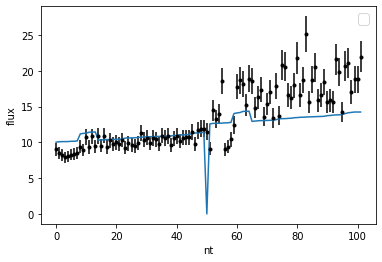

In [60]:
theta_fit = eta_fit,D_fit
labels = "eta","D"
stepi = eta_gss,D_gss
pv = (1329*pow(10,-Hv/5)/(D_fit*0.001))**2
print(f'eta = {eta_fit}\nD={D_fit}')
print('pv=',pv)
from IPython.display import display, Math
for i in range(2):
    txt = "\mathrm{{{3}}} = {0:.3f}_{{{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(theta_fit[i],stepi[i][0],stepi[i][1], labels[i])
    display(Math(txt))
print(Math(txt))

flux_fit = Model_neatm_jhx(theta_fit,x,lamdai)
print(f'eta = {eta_fit}\nD={D_fit}')
print('pv=',pv)
print('loss= ',loss_func(y,yerr,flux_fit))
plt.plot(nt, flux_fit)
plt.errorbar(nt, y, yerr=yerr, fmt=".k", capsize=0)
plt.legend(fontsize=14)
plt.xlabel("nt")
plt.ylabel("flux");

/tmp/ipykernel_663526/4220248000.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
No handles with labels found to put in legend.


570711568513.4287


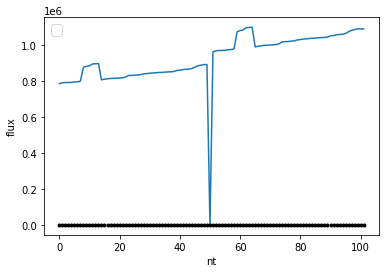

In [61]:
theta_fit = eta_fit,99000
flux_fit = Model_neatm_jhx(theta_fit,x,lamdai)
print(loss_func(y,yerr,flux_fit))
plt.plot(nt, flux_fit)
plt.errorbar(nt, y, yerr=yerr, fmt=".k", capsize=0)
plt.legend(fontsize=14)
plt.xlabel("nt")
plt.ylabel("flux");
